In [1]:
YEAR = 2022 # Update this variable to the desired year

In [2]:
# Create a folder named "All_documents_merged" if it does not already exist.
# This folder is intended to store preprocessed data for potential reuse, thereby saving time in case the notebook needs to be rerun.

import os

# Define the folder path
folder_path = f"./All_documents_merged"

# Check if the folder exists
if not os.path.exists(folder_path):
  # Create the folder
  os.makedirs(folder_path)
  print(f"Folder '{folder_path}' created successfully!")
else:
  print(f"Folder '{folder_path}' already exists.")


Folder './All_documents_merged' already exists.


In [3]:
# Unzip the Data Sources.zip in a folder called Data Sources
import zipfile
with zipfile.ZipFile('Data Sources.zip', 'r') as zip_ref:
    zip_ref.extractall('Data Sources/.')

# 1. Setup and Configuration

## Requirements

In [4]:
%%capture
!pip install sentence_transformers==2.5.1
!pip install llama-parse
!pip install langchain==0.1.11
!pip install langchain_anthropic
!pip install faiss-gpu


### Hugging Face and Anthropic Account Setup

To utilize the Hugging Face and Anthropic platforms, you'll need to create accounts and obtain API tokens for authentication. Follow these steps:

#### Hugging Face Account Setup

1. **Sign Up**: Visit the [Hugging Face website](https://huggingface.co) and register for a new account.
2. **Verify Email**: Verify your email address by following the instructions sent to your inbox.
3. **Login**: Log in to your Hugging Face account using your credentials.
4. **Access Account Settings**: Navigate to your account settings.
5. **Generate Token**: Look for an option related to API tokens or developer settings and generate a new token.
6. **Copy Token**: Copy the generated API token to your clipboard.
7. **Paste Token**: When prompted by the Hugging Face CLI, paste the token to authenticate your access.

#### Anthropic Account Setup

1. **Visit the Anthropic Website**: Go to the [Anthropic website](https://anthropic.com) to create an account.
2. **Sign Up**: Register for an account by providing the required information.
3. **Verify Email**: Verify your email address by following the instructions sent to your inbox.
4. **Login**: Log in to your Anthropic account using your credentials.
5. **Access Account Settings**: Navigate to your account settings.
6. **Generate Token**: Look for an option to generate an API token or access key.
7. **Copy Token**: Copy the generated token to your cli

####  LLamaIndex Account Setup

1. **Visit the LlamaIndex Website**: Go to the [LlamaIndex](https://cloud.llamaindex.ai/) to create an account.
2. **Sign Up**: Register for an account by providing the required information.
3. **Verify Email**: Verify your email address by following the instructions sent to your inbox.
4. **Login**: Log in to your Anthropic account using your credentials.
5. **Generate Token**: Look for an option to generate an API token or access key.
6. **Copy Token**: Copy the generated token to your cli

In [5]:
!nvidia-smi

Wed Mar 20 04:03:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              2W /   35W |     309MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Insert Your Tokens

In [6]:
import os

# Set Hugging Face token
os.environ['HF_TOKEN'] = 'key'

# Set Anthropic API key
os.environ["ANTHROPIC_API_KEY"] = 'key'

# Set LLAMA Cloud API key
os.environ["LLAMA_CLOUD_API_KEY"] = "key"

# Print a message indicating completion
print("Setup and configuration complete.")


Setup and configuration complete.


## Importing required modules

In [8]:
# Data manipulation
import numpy as np
import pandas as pd
import re
import time
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Language models and NLP libraries
import sentence_transformers
from transformers import pipeline
import nltk

# Document Parser
import nest_asyncio
nest_asyncio.apply()
from llama_parse import LlamaParse

# Document processing and analysis
import langchain
import langchain_anthropic
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import SentenceTransformerEmbeddings
import faiss
from langchain.vectorstores import FAISS

# Chat models and prompts
from langchain_anthropic import ChatAnthropic

# Miscellaneous
from tqdm import tqdm
import warnings

# Supress warnings
warnings.filterwarnings("ignore")


In [9]:
sns.set_style("darkgrid")
plotly_template = "plotly_white"
color_palette = sns.color_palette()
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Environment Verification

In [10]:
# List of necessary libraries to check versions
modules = [
    np, pd, faiss, sentence_transformers, langchain
]

# Print versions of imported modules
for module in modules:
    try:
        print(f"{module.__name__}: {module.__version__}")
    except AttributeError:
        print(f"{module.__name__}: Version not found")

numpy: 1.26.4
pandas: 2.1.4
faiss: 1.8.0
sentence_transformers: 2.5.1
langchain: 0.1.11


# 2. Data Understanding and Exploration

## Data Loading
Load datasets (PDF names, activity metrics, synonyms, training data, sample submission).

In [11]:
pdf_names = pd.read_csv('PDFnames.csv')
AMKEY_qs = pd.read_csv('AMKEY_GoldenStandard.csv')
AMKEY_Synonyms = pd.read_csv('ActivityMetricsSynonyms.csv')
train = pd.read_csv('Train.csv')
sample_sub = pd.read_csv('SampleSubmission.csv')

## Data Overview
Explore the content of each dataset.

In [12]:
def search_file(filename):
    """
    Searches for a file in a folder and its subfolders.

    Args:
    folder: The folder to search in.
    filename: The name of the file to search for.

    Returns:
    The path to the file if found, or None otherwise.
    """
    folder= r'./'
    for root, dirs, files in os.walk(folder):
        if filename in files:
            return os.path.join(root, filename)

    return None

In [13]:
pdf_names.head()

,ID,File Name
0,Oceana1.pdf,Oceana_Group_Sustainability_Report_2022.pdf
1,Ssw.pdf,ssw-IR22.pdf
2,Sasol.pdf,SASOL Sustainability Report 2023 20-09_0.pdf
3,Impala.pdf,ESG-spreads.pdf
4,Clicks.pdf,Clicks-Sustainability-Report-2022.pdf


In [14]:
AMKEY_qs.head()

,AMKEY,ActivityMetric
0,3,Advisory fees as per income statement
1,6,Air emissions of the following pollutants: (1) CO
2,7,Air emissions of the following pollutants: (2)...
3,8,Air emissions of the following pollutants: (3)...
4,9,Air emissions of the following pollutants: (4)...


In [15]:
AMKEY_Synonyms.head()

,AMKEY,Group,ActivityMetric,ClientMetric
0,7,Impala,Air emissions of the following pollutants: (2)...,Total indirect Nox
1,7,Sasol,Air emissions of the following pollutants: (2)...,Nitrogen oxides (NOx) (kilotons)
2,8,Sasol,Air emissions of the following pollutants: (3)...,Sulphur oxides (SOx ) (kilotons)
3,8,Ssw,Air emissions of the following pollutants: (3)...,SO2 emissions
4,8,Impala,Air emissions of the following pollutants: (3)...,Total direct SO2 + Total indirect SO2


In [16]:
train.head()

,ID,2021_Value,2020_Value,2019_Value
0,3_X_Absa,NaN,NaN,NaN
1,6_X_Absa,NaN,NaN,NaN
2,7_X_Absa,NaN,NaN,NaN
3,8_X_Absa,NaN,NaN,NaN
4,9_X_Absa,NaN,NaN,NaN


Visualize key aspects of the data (e.g., null value distribution)\
Case study: **Clicks**

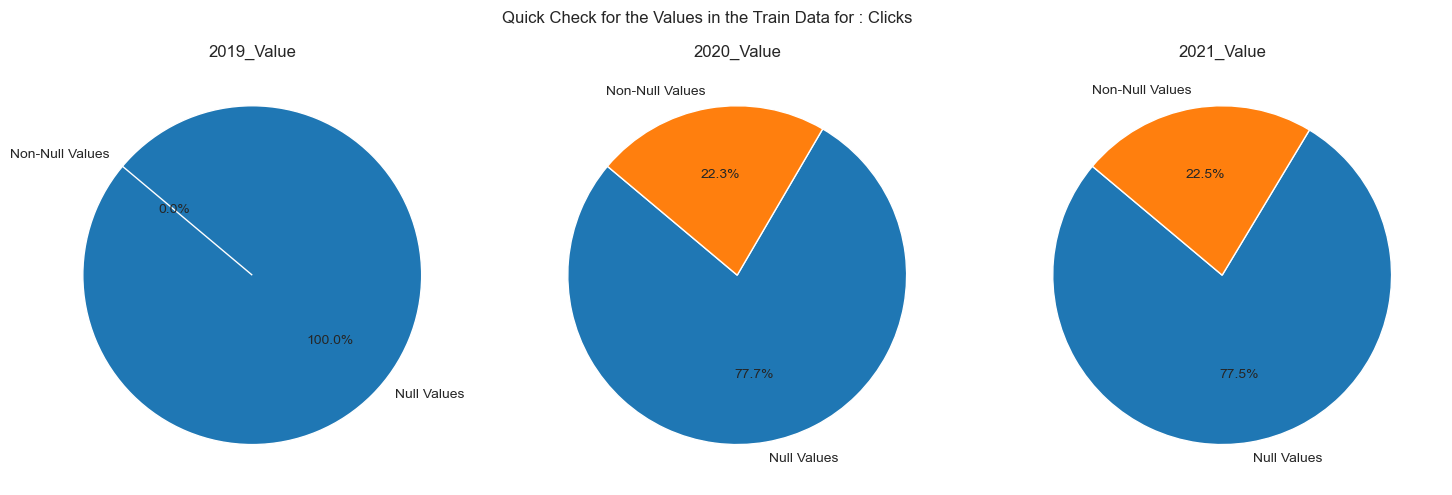

In [17]:
Choosen_doc='Clicks'

# Filter the DataFrame for Clicks
clicks_df = train[train['ID'].str.contains(Choosen_doc)].copy()

# Create subplots for each year
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each year and create a pie chart
for i, year in enumerate(['2019_Value', '2020_Value', '2021_Value']):
    # Count null and non-null values for the year
    null_count = clicks_df[year].isnull().sum()
    non_null_count = len(clicks_df) - null_count

    # Create labels and values for the pie plot
    labels = ['Null Values', 'Non-Null Values']
    sizes = [null_count, non_null_count]

    # Create a pie plot with specified colors
    axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=color_palette)
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axs[i].set_title(year)

# Set title for the entire figure
fig.suptitle(f'Quick Check for the Values in the Train Data for : {Choosen_doc}')

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
pdf = pdf_names.copy()
pdf['File path'] = pdf['File Name'].apply(search_file)
pdf['Group'] = pdf['ID'].str.replace('.pdf', '')

# Mapping dictionary
group_mapping = {
    'Oceana1': 'Oceana1&2',
    'Oceana2': 'Oceana1&2',
    'Uct1': 'Uct1&2',
    'Uct2': 'Uct1&2'
}

# Apply the mapping
pdf['Group'] = pdf['Group'].map(group_mapping).fillna(pdf['Group'])
pdf.head()

,ID,File Name,File path,Group
0,Oceana1.pdf,Oceana_Group_Sustainability_Report_2022.pdf,./Data Sources\Multiple source data\Oceana_Gro...,Oceana1&2
1,Ssw.pdf,ssw-IR22.pdf,./Data Sources\Unstructured data\ssw-IR22.pdf,Ssw
2,Sasol.pdf,SASOL Sustainability Report 2023 20-09_0.pdf,./Data Sources\Structured data\SASOL Sustainab...,Sasol
3,Impala.pdf,ESG-spreads.pdf,./Data Sources\Structured data\ESG-spreads.pdf,Impala
4,Clicks.pdf,Clicks-Sustainability-Report-2022.pdf,./Data Sources\Structured data\Clicks-Sustaina...,Clicks


## PDFs Parsing & Exploration

### Parsing

**`create_documents_from_string(document_text)`**  
*Purpose*: This function is designed to process a single string representing a PDF document, where pages are separated by the delimiter '\n---'. It splits the string into individual pages and creates a new document object for each page, resulting in a list of documents where each document corresponds to a page from the original string.

---

**`insert_activity_metrics(document, dataframe)`**  
*Purpose*: This function aims to enhance a given document by integrating specific metrics into it. It iterates through a dataframe containing pairs of client metrics and activity metrics. For each pair, the function searches the document for occurrences of the client metric and inserts the corresponding activity metric in parentheses immediately following each occurrence. The process involves adjusting for text insertion to maintain the correct positioning of metrics within the document.

---

In [19]:
def create_documents_from_string(document_text):
    # Split the string into pages
    pages = document_text.split('\n---')

    # List to store the Document objects
    documents = []

    # Iterate over each page and create a Document
    for page_number, page_content in enumerate(pages, start=1):
        doc = Document(page_content=page_content, metadata={"source": "local", "page": page_number})
        documents.append(doc)

    return documents

def insert_activity_metrics(document, dataframe):
    for _, row in dataframe.iterrows():
        client_metric = row['ClientMetric']
        activity_metric = row['ActivityMetric']

        # Find all start indices of the client_metric in the document
        start_indices = [i for i in range(len(document)) if document.startswith(client_metric, i)]

        # Offset for added characters
        offset = 0

        for index in start_indices:
            # Adjust the index for the offset caused by previously inserted strings
            adjusted_index = index + offset
            insert_text = f"({activity_metric})"
            # Insert the activity_metric
            document = document[:adjusted_index + len(client_metric)] + insert_text + document[adjusted_index + len(client_metric):]

            # Update the offset
            offset += len(insert_text)

    return document

---

**File Path and Dictionary Handling**

*Purpose*: This code segment either loads a pre-existing dictionary of documents from a file or creates and saves one if it doesn't exist. It processes PDF files, adding activity metrics to each, converts them into document objects, and then selectively merges these documents based on their IDs. This process is designed for efficient data management, either reusing stored data or handling the creation and storage of new processed document data.

---

In [33]:
start_time = time.perf_counter()
# Define the file path
file_path = "./All_documents_merged/all_documents_merged.pkl"

# Check if file exists for loading
if os.path.exists(file_path):
    # Load the dictionary
    with open(file_path, "rb") as f:
        d = pickle.load(f)
        all_documents_merged =d.copy()
    print("Dictionary loaded successfully.")
else:
    all_documents = {}
    for file, ID in tqdm(pdf[['File Name', 'ID']].to_numpy()):
        row = pdf[pdf['File Name'] == file]
        parser = LlamaParse(
            result_type="markdown"  # "markdown" and "text" are available
        )
        document_text = parser.load_data(row['File path'].iloc[0])[0].text
        # adding the synonyms
        modified_document = insert_activity_metrics(document_text, AMKEY_Synonyms[AMKEY_Synonyms.Group == row['Group'].iloc[0]])

        documents = create_documents_from_string(modified_document)
        all_documents[ID] = documents

    all_documents_merged = {
        'Clicks': all_documents['Clicks.pdf'],
        'Absa': all_documents['Absa.pdf'],
        'Ssw': all_documents['Ssw.pdf'],
        'Sasol': all_documents['Sasol.pdf'],
        'Impala': all_documents['Impala.pdf'],
        'Picknpay': all_documents['Picknpay.pdf'],
        'Distell': all_documents['Distell.pdf'],
        'Tongaat': all_documents['Tongaat.pdf'],
        'Oceana1&2': all_documents['Oceana1.pdf'] + all_documents['Oceana2.pdf'],
        'Uct1&2': all_documents['Uct1.pdf'] + all_documents['Uct2.pdf']
    }

    # Save the merged dictionary with error handling
    try:
        with open(file_path, "wb") as f:
            pickle.dump(all_documents_merged, f)
        print("Dictionary saved successfully.")
    except Exception as e:
        print(f"Error saving dictionary: {e}")

end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Dictionary loaded successfully.
Elapsed time: 0.01 seconds


### Exploration

---

**Null vs Non-Null Counts for Each Year Analysis**

*Purpose*: This code calculates and visualizes the null and non-null value counts for each year in a dataset, broken down by document ID. It generates stacked bar plots to display these counts, providing a clear comparison across different years.

---

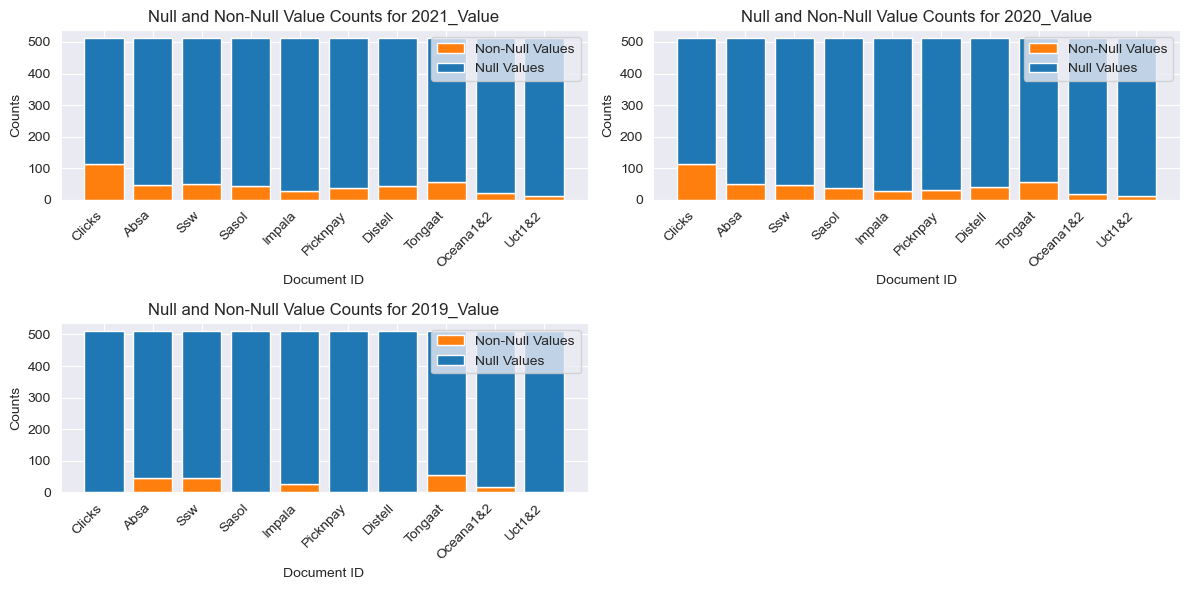

In [21]:
# Initialize lists to store null and non-null counts for each year
years = ['2021_Value', '2020_Value', '2019_Value']
null_counts = []
non_null_counts = []

for year in years:
    null_count = []
    non_null_count = []
    for doc_ID in all_documents_merged.keys():
        df = train[train['ID'].str.contains(doc_ID)]
        null_count.append(df[year].isnull().sum())
        non_null_count.append(len(df) - null_count[-1])

    null_counts.append(null_count)
    non_null_counts.append(non_null_count)

# Plot stacked bar plots for each year
plt.figure(figsize=(12, 6))
for i, year in enumerate(years):
    plt.subplot(2, 2, i+1)
    plt.bar(np.arange(len(all_documents_merged)), non_null_counts[i], color=color_palette[1], label='Non-Null Values')
    plt.bar(np.arange(len(all_documents_merged)), null_counts[i], color=color_palette[0], label='Null Values', bottom=non_null_counts[i])
    plt.xlabel('Document ID')
    plt.ylabel('Counts')
    plt.title(f'Null and Non-Null Value Counts for {year}')
    plt.xticks(np.arange(len(all_documents_merged)), all_documents_merged.keys(), rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()

---

**Function: `plot_text_stats(all_documents_merged)`**

*Purpose*: This function calculates and plots text statistics (number of numerical tokens and total word count) for each document in a dataset. It displays these statistics in a bar chart, annotated with the total number of pages per document.

---

In [22]:
def plot_text_stats(all_documents_merged):
    # Initialize counts for all documents
    all_stats = {}

    for doc_ID, doc_content in tqdm(all_documents_merged.items()):
        # Initialize counts for the current document
        num_numbers = 0

        # Iterate over pages in the document
        for page in doc_content:
            # Extract text data from the page
            text_data = ' '.join(page.page_content)

            # Tokenize the text data
            tokens = nltk.word_tokenize(text_data)

            # Update counts for the current group
            num_numbers += sum(1 for word in tokens if word.isdigit())

        # Calculate statistics for the current document
        total_words = sum(len(token) for token in nltk.word_tokenize(' '.join([page.page_content for page in doc_content])))

        # Store counts and statistics for the current document
        all_stats[doc_ID] = {
            'Numbers': num_numbers,
            'Total Words': total_words,
        }

    # Create a DataFrame from the collected statistics
    stats_df = pd.DataFrame.from_dict(all_stats, orient='index')

    # Display the DataFrame
    print(stats_df)

    # Set the style of the visualization
    sns.set_style("whitegrid")

    # Plotting bar chart
    ax = stats_df.plot(kind='bar', figsize=(14, 8), color=['skyblue', 'salmon'])

    # Customizing the plot
    plt.title('Text Statistics', fontsize=16)
    plt.xlabel('Document ID', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)

    # Annotate each bar with the total number of pages
    for idx, (doc_ID, row) in enumerate(stats_df.iterrows()):
        ax.text(idx, max(row['Numbers'], row['Total Words']) + 0.05, f'Pages: {len(all_documents_merged[doc_ID])}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


           Numbers  Total Words
Clicks        1772        39260
Absa          9271        38287
Ssw          40391       767318
Sasol         6762       193022
Impala        7879       207687
Picknpay      3739        80209
Distell       3295        30243
Tongaat       9834       240018
Oceana1&2     7514       137891
Uct1&2       20520       340911


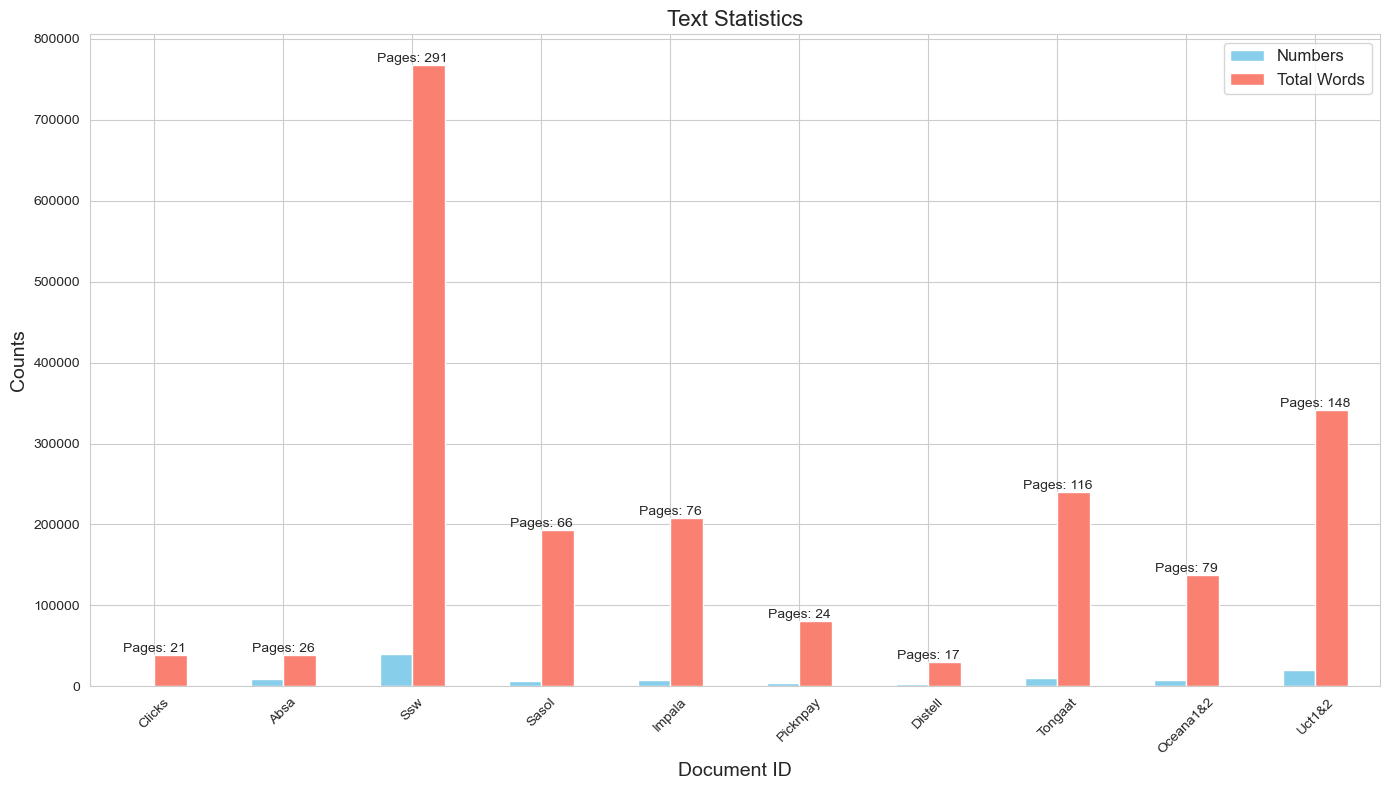

In [23]:
plot_text_stats(all_documents_merged)

---

**Function: `Analyzing_Group_Documents(doc)`**

*Purpose*: This function generates summaries for sections labeled 'about' or 'introduction' in each document of a given set, using a predefined summarization model. It prints these summaries along with respective group IDs, handling any exceptions encountered during the process.

---

In [24]:
def Analyzing_Group_Documents(doc):
    MIN_LENGTH = 20
    MAX_LENGTH = 300
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    for ID in tqdm(doc.keys(), desc="Analyzing Group Documents"):
        print()
        text = ''
        print(f'Introduction for Group: {ID}')
        try:
            for page in range(len(doc[ID])):
                if f'about {ID}'.lower() in doc[ID][page].page_content.lower():
                    tokens = doc[ID][page].page_content.split()
                    token_count = len(tokens)
                    if token_count<MAX_LENGTH:
                        MAX_LENGTH=token_count
                    else:
                        MAX_LENGTH=300
                    summarized_content = summarizer(doc[ID][page].page_content, max_length=MAX_LENGTH, min_length=MIN_LENGTH, do_sample=True)
                    text += summarized_content[0]['summary_text']
                elif f'introduction'.lower() in doc[ID][page].page_content.lower():
                    tokens = doc[ID][page].page_content.split()
                    token_count = len(tokens)
                    if token_count<MAX_LENGTH:
                        MAX_LENGTH=token_count
                    else:
                        MAX_LENGTH=300
                    summarized_content = summarizer(doc[ID][page].page_content, max_length=MAX_LENGTH, min_length=MIN_LENGTH, do_sample=True)
                    text += summarized_content[0]['summary_text']
                else:
                    pass

            if len(text) != 0:
                print()
                print(text)
                print('\n')
            else:
                print(f'Sorry! Unable to retrieve information about {ID}.\n')
        except Exception:
            print(f'Sorry! Unable to retrieve information about {ID}.\n')
            pass
        print ('-'*60)

**Please note:** The next cell may take approximately **10-11 minutes** to complete. However, it provides only a brief overview of select groups, which may not be essential for your current needs. Therefore, feel free to skip it, as it will not impact the outcome of your task.

In [25]:
start_time = time.perf_counter()
Analyzing_Group_Documents(all_documents_merged)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Analyzing Group Documents:   0%|          | 0/10 [00:00<?, ?it/s]


Introduction for Group: Clicks


Analyzing Group Documents:  10%|█         | 1/10 [00:13<02:03, 13.70s/it]


The group continues to enhance its disclosure against ESG indicators from a range of global ratings agencies and guidance documents. It is specifically working towards increased disclosure and transparency on climate-related risks and opportunities.Clicks Group has a total headcount of 16,492 including 15,646 South African-based employees. Group turnover increased by 6.0% to R39.6 billion. Return on equity increased to 48.0%.


------------------------------------------------------------

Introduction for Group: Absa
Sorry! Unable to retrieve information about Absa.

------------------------------------------------------------

Introduction for Group: Ssw


Analyzing Group Documents:  30%|███       | 3/10 [00:52<02:06, 18.03s/it]


In 2022, 74% of employees completed induction/refresher training. US PGM operations focused on sustaining and increasing participation in leadership development courses.Sibanye-Stillwater has unveiled its ICT strategic plan for 2022. It is committed to a hybrid cloud model, combining public cloud capabilities with private cloud services and on-premises infrastructure. The company has also implemented ISO 27001 (information security) for its SA and Group systems.Keliber has 851 heritage sites across its SA and US operations. They include grave sites, iron age and stone age archaeological finds, and historical mine buildings. Keliber will cooperate on monitoring programmes with other companies.An estimated 40% - 45% real risk reduction in pe Residual Risk Ratings (RRRs) at the end of Q4 2023 for all identified environmental risks. Limiting GHG emissions, prough various initiatives and interventions, to below pe 2023 stated carbon budgets for respective operations. For SA gold, achieve a

Token indices sequence length is longer than the specified maximum sequence length for this model (2643 > 1024). Running this sequence through the model will result in indexing errors
Analyzing Group Documents:  40%|████      | 4/10 [02:49<05:12, 52.09s/it]

Sorry! Unable to retrieve information about Sasol.

------------------------------------------------------------

Introduction for Group: Impala


Analyzing Group Documents:  50%|█████     | 5/10 [03:17<03:41, 44.34s/it]

Sorry! Unable to retrieve information about Impala.

------------------------------------------------------------

Introduction for Group: Picknpay
Sorry! Unable to retrieve information about Picknpay.

------------------------------------------------------------

Introduction for Group: Distell
Sorry! Unable to retrieve information about Distell.

------------------------------------------------------------

Introduction for Group: Tongaat


Analyzing Group Documents:  80%|████████  | 8/10 [03:25<00:39, 19.76s/it]

Sorry! Unable to retrieve information about Tongaat.

------------------------------------------------------------

Introduction for Group: Oceana1&2


Analyzing Group Documents:  90%|█████████ | 9/10 [04:27<00:29, 29.10s/it]Your max_length is set to 300, but your input_length is only 290. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=145)



The report is the result of a four-month investigation into the fishing industry in Ghana. The aim is to assess the impact of the industry on the country's economy. The report was published by the Ghanaian Institute of Fisheries and Aquaculture (GISAF) GISAF is a non-profit organisation based in the city of Accra.Oceana Group Limited’s (hereafter referred to as Oceana or the Group) 2022 sustainability report provides a review of the Group's performance and prospects. It aims to reflect the way sustainability is integrated into our business in accordance with current and emerging disclosure guidance relevant to our operating geographies.The divisional managers oversee the day-to-day operations and activities of the Group. The Board of directors are responsible for: Steering and setting strategic direction and setting policy and planning. The board also oversees and monitoring policy and plans for the future.Oceana has instilled a purpose-led culture with a meaningful shift towards an e

Analyzing Group Documents: 100%|██████████| 10/10 [05:09<00:00, 30.95s/it]

Sorry! Unable to retrieve information about Uct1&2.

------------------------------------------------------------
Elapsed time: 316.95 seconds


# 3. Data Preprocessing

## Document Cleaning

---

**Function: `fix_issues(doc, year=YEAR)`**  
*Purpose*: This function replaces fiscal year abbreviations with their full year representations in the content of documents and provides optional year-specific replacements. It confirms completion with a message indicating the fix of text issues in all documents.

---

**Function: `delete_unnecessary_pages(doc, year=YEAR)`**  
*Purpose*: Designed to remove the first and last pages of documents (except the first page only for 'Absa') and any pages not containing information about a specified year. It reports the number of pages removed from each document.

---

**Function: `Remove_unnecessary_information(doc, year="YEAR")`**  
*Purpose*: This function clears specific unwanted text patterns from documents, based on a predefined mapping of document IDs to replacement text. It uses a helper function to streamline the content cleaning process.

---

**Function: `summarize_texts(doc, year=YEAR)`**  
*Purpose*: Targets selected documents for summarization of pages exceeding a specified token length, using a defined summarization model. It reports the count of summarized pages for each document.

---

In [26]:
def fix_issues(doc,year=YEAR):

    for ID in tqdm(doc.keys()):
        for i in range(len(doc[ID])):
            doc[ID][i].page_content = doc[ID][i].page_content.replace('FY23', '2023') \
                                              .replace('FY22', '2022') \
                                              .replace('FY21', '2021') \
                                              .replace('FY20', '2020') \
                                              .replace('FY19', '2019')
            if year!=2022:
                doc[ID][i].page_content = doc[ID][i].page_content.replace(f'FY{str(year)[-2:]}', str(year))

    print('Text issues fixed for all documents!')


In [27]:
def delete_unnecessary_pages(doc,year=YEAR):
    # Delete first and last page in all documents (Only for Absa, remove only the first page)
    for ID in tqdm(doc.keys()):
        initial_pages = len(doc[ID])
        if ID != 'Absa':
            del doc[ID][-1]
        del doc[ID][0]

        # Delete pages that does not have information about 2022
        last=len(doc[ID])
        page=0
        year=str(year)
        while page<last:
            if year not in doc[ID][page].page_content:
                del doc[ID][page]
                last-=1
            else:
                page+=1

        print(f"Pages successfully removed from document '{ID}': from {initial_pages} pages to {len(doc[ID])} pages.")


In [28]:
def Remove_unnecessary_information(doc, year="YEAR"):
    def clean_content(id_content, replacements):
        for page in range(len(doc[id_content])):
            for old, new in replacements:
                doc[id_content][page].page_content = doc[id_content][page].page_content.replace(old, new)

    replacements_map = {
        'Absa': [
            ('Absa Group Limited 2022 Environmental, Social and Governance Indicators', ''),
            ('\n## Environment\n\nSocial\nTax\nGovernance\nShareholders\n\n', '')
        ],
        'Ssw': [
            ('SIBANYE-STILLWATER INTEGRATED REPORT 2022', ''),
            ('\n## OUR BUSINESS AND LEADERSHIP DRIVES US FORWARD AND INCENTIVIZES PERFORMANCE DELIVERY INFORMATION', '')
        ],
        'Distell': [('Distell ESG Appendix 2022', '')],
        'Clicks': [('CLICKS GROUP SUSTAINABILITY OVERVIEW AND ESG DATABOOK 2022', '')],
        'Picknpay': [
            ('ESG Performance Summary and Databook 2023', ''),
            ('www.pnp.co.za', '')
        ],
        'Sasol': [
            ('SASOL SUSTAINABILITY REPORT 2023', ''),
            ('INTRODUCTION\n\n## SUSTAINABILITY PERFORMANCE AGAINST OUR FOCUS AREAS\n\n## DATA AND ASSURANCE\n\n## ANNEXURES\n\n## SAFE AND ENDURING OPERATIONS\n\nSAFE AND ENDURING OPERATIONS', ''),
            ('SUSTAINABILITY PERFORMANCE AGAINST OUR FOCUS AREAS', ''),
            ('INTRODUCTION', ''),
            ('DATA AND ASSURANCE', ''),
            ('ANNEXURES', '')
        ],
        'Impala': [
            ('Implats ESG Report 2023', ''),
            ('ESG Report 2023', '')
        ],
        'Tongaat': [
            ('TONGAAT HULETT 2021 ESG REPORT', ''),
            ('www.tongaat.com', '')
        ],
        'Oceana1&2': [('OCEANA GROUP Sustainability Report 2022', '')],
        'Uct1&2': [
            ('University of Cape Town Annual Report 2021', ''),
            ('www.uct.ac.za', ''),
            ('\n## Report of the Chair of Council for 2021\n\nInstitutional Forum Report of the Report of the Annual Financial Statements for 2021\n\n### Report on UCT Operations During 2021\n\n### REPORT ON UCT OPERATIONS DURING 2021', '')
        ]
    }

    for ID in tqdm(doc.keys()):
        if ID in replacements_map:
            clean_content(ID, replacements_map[ID])



In [29]:
def summarize_texts(doc,year=YEAR):
    MIN_LENGTH=20
    MAX_LENGTH=300
    Selected_docs=['Uct1&2','Oceana1&2','Ssw','Tongaat']

    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    for ID in tqdm(Selected_docs, desc="Processing documents"):
        summarized_pages=0
        for page in tqdm(range(len(doc[ID]))):
            tokens = doc[ID][page].page_content.split()  # Split by whitespace
            token_count = len(tokens)
            if token_count > MAX_LENGTH and '|---|\n' not in doc[ID][page].page_content:
                # Summarize the content
                try :
                    summarized_content = summarizer(doc[ID][page].page_content, max_length=MAX_LENGTH, min_length=MIN_LENGTH, do_sample=True)
                    doc[ID][page].page_content = summarized_content[0]['summary_text']
                    summarized_pages += 1
                except Exception:
                    pass
        print(f"{summarized_pages} pages summarized for document: {ID}")

## Preprocessing Pipeline

In [30]:
def preprocessing(doc,year=YEAR):
    fix_issues(doc,year)
    Remove_unnecessary_information(doc,year=YEAR)
    delete_unnecessary_pages(doc,year)
    summarize_texts(doc,year=YEAR)

In [34]:
start_time = time.perf_counter()
preprocessing(all_documents_merged,year=YEAR)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

100%|██████████| 10/10 [00:00<00:00, 1248.83it/s]


Text issues fixed for all documents!


100%|██████████| 10/10 [00:00<00:00, 5093.27it/s]


Pages successfully removed from document 'Clicks': from 21 pages to 9 pages.
Pages successfully removed from document 'Absa': from 26 pages to 22 pages.
Pages successfully removed from document 'Ssw': from 291 pages to 214 pages.
Pages successfully removed from document 'Sasol': from 66 pages to 40 pages.
Pages successfully removed from document 'Impala': from 76 pages to 44 pages.
Pages successfully removed from document 'Picknpay': from 24 pages to 15 pages.
Pages successfully removed from document 'Distell': from 17 pages to 11 pages.
Pages successfully removed from document 'Tongaat': from 116 pages to 11 pages.
Pages successfully removed from document 'Oceana1&2': from 79 pages to 44 pages.
Pages successfully removed from document 'Uct1&2': from 148 pages to 24 pages.


Processing documents:  25%|██▌       | 1/4 [01:32<04:37, 92.55s/it]

11 pages summarized for document: Uct1&2



Processing documents:  50%|█████     | 2/4 [03:11<03:13, 96.59s/it]

15 pages summarized for document: Oceana1&2



Processing documents:  75%|███████▌  | 3/4 [10:07<04:02, 242.38s/it]

53 pages summarized for document: Ssw



Processing documents: 100%|██████████| 4/4 [10:21<00:00, 155.46s/it]

2 pages summarized for document: Tongaat
Elapsed time: 629.31 seconds


## Saving Preprocessed Data

In [35]:
file_path = './All_documents_merged/all_documents_merged_preprocessed.pkl'

# Check if the file exists
if os.path.exists(file_path):
    # Load the file
    with open(file_path, "rb") as f:
        d = pickle.load(f)
        all_documents_merged=d.copy()
    message = "Dictionary loaded successfully."
else:
    with open(file_path, "wb") as f:
        pickle.dump(all_documents_merged, f)
    message = "A dictionary has been created and saved."
print(message)

Dictionary loaded successfully.


## Text Statistics after Preprocessing

100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


           Numbers  Total Words
Clicks        1312        20777
Absa          7156        31386
Ssw          32605       481087
Sasol         5976       115860
Impala        5989       129737
Picknpay      3753        56253
Distell       3059        23177
Tongaat        635        23420
Oceana1&2     5735        55274
Uct1&2        1588        32788


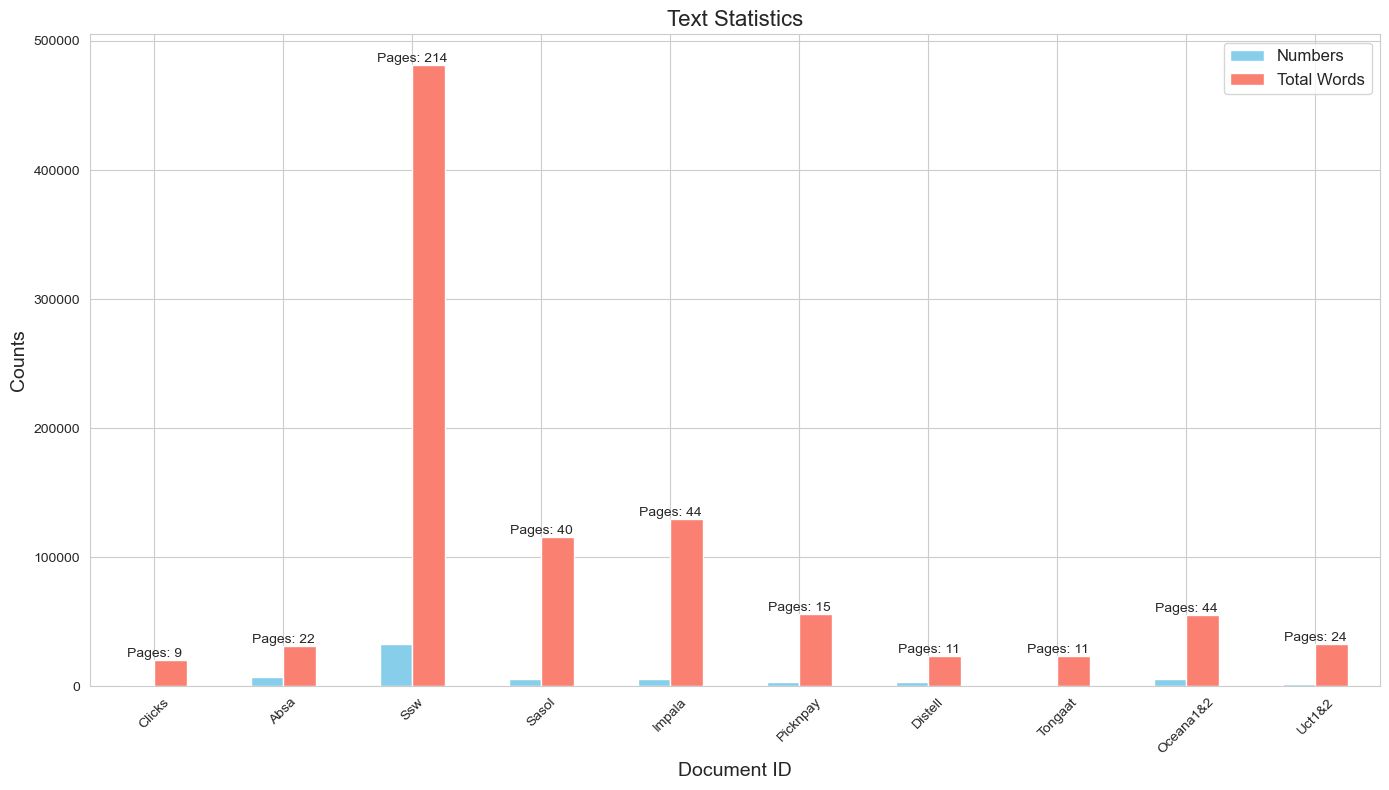

In [36]:
plot_text_stats(all_documents_merged)

# 4. Embeddings and VectorStore

Choose an appropriate embedding model (e.g., GIST).

In [37]:
def select_embeddings_model(LLM_service="GIST"):
    """Connect to the embeddings API endpoint by specifying
    the name of the embedding model."""

    # Speed

    if LLM_service == "all-MiniLM-L6-v2":
        embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

    # Performance

    if LLM_service == "GIST":
        embeddings = SentenceTransformerEmbeddings(model_name = "avsolatorio/GIST-Embedding-v0")

    if LLM_service == "GIST_LARGE":
        embeddings = SentenceTransformerEmbeddings(model_name = "avsolatorio/GIST-large-Embedding-v0")

    return embeddings

Create a FAISS vector database using the chosen embeddings and documents.

In [38]:
def create_vectorstore(embeddings,documents):
    """Create a FAISS vector database."""

    vector_store = FAISS.from_documents(
        documents=documents,
        embedding=embeddings,
    )
    return vector_store

# 5. LLM Selection and Prompt Engineering

I experimented with various models, including local implementations. However, the local setups did not yield satisfactory results, particularly in the output quality. Consequently, I explored several models via API calls, such as GPT-3.5. Surprisingly, **Claude 3** exhibited impressive performance, and even the sonnet version showed promising results despite being more cost-effective than Opus. Ultimately, after careful consideration, **Opus** emerged as the chosen model for further usage.

In [39]:
def LLM_choice(name='opus'):
    if name == 'sonnet':
        model_name = "claude-3-sonnet-20240229"
    elif name == "opus":
        model_name = "claude-3-opus-20240229"
    else:
        return "You need to choose between 'sonnet' or 'opus'"

    llm = ChatAnthropic(model_name=model_name, temperature=0.1, max_tokens_to_sample=4096)
    return llm

## Prompt Template Design

The prompt template for the Q&A language model is designed to extract statistical variables from a given context, focusing on data from the years 2021 and 2022. Here's a breakdown of its key features:

1. **Contextual Relevance and Year Specification**: The template emphasizes the importance of extracting information only from the relevant years (2021 and 2022), ensuring the model disregards data from other periods. This helps in focusing the response on the most pertinent information.

2. **Conversion and Standardization of Units**: It provides specific instructions for converting various units (like percentages, currencies, and volumes) to a standardized form. This step is crucial for maintaining consistency and accuracy, especially when dealing with large datasets or comparisons.

3. **Formatting Rules for Numbers**: The template includes rules for formatting numbers (e.g., removing commas, spaces). Such uniformity is essential for later data processing or analysis, as it avoids common errors and inconsistencies that can arise from varied number formats.

4. **Handling Missing Data**: The instruction to assign 'N/A' when a variable is not present in the context is a systematic way of dealing with missing information. This approach acknowledges gaps in data while maintaining the structure and readability of the output.

5. **Output Structuring**: The output format is clearly defined, aligning variable names with their corresponding values from 2021 and 2022. This structured approach not only aids in clarity but also prepares the data for straightforward post-processing or integration into databases and reports.

Overall, the template is crafted to enhance precision, consistency, and clarity in the model's output, making the extracted data ready for further analysis or reporting.

In [40]:
template = """
Utilize the provided context to respond to the set of questions below. First, carefully read through the context to identify the relevant statistical data related to the given variables from the years 2021 and 2022 (Disregard information from other years). Remember, the key is to make your reasoning process as logical as possible.
Do not explain your reasoning and do not write 'here are the...' or 'the variable X is ...' or 'variable not provided in the context'
the following rules should be applied to the generated values: 46% --> 46 | 165 million --> 165000000 | R187 million --> 187000000 | R39.6 billion --> 39600000000 | Rbn 2.4 or 2.4 Rbn or 2.4 bn or 2.4 billion --> 2400000000 | level 4 --> 4| kg should be converted to tons e.g: 1231024 kg --> 1231.024 | Kilolitres should be converted to Megalitres e.g 42198 Kilolitres --> 42.198 | Do not write large numbers with ',' eg: 1245,165 (incorrect), 1245145(correct) | if the number found in context is with space remove the space e.g: 14 100 --> 14100. 
your answer should strictly adhere the following format (if the value is not found for a given year simply assign 'N/A' for that year): 
"
- Variable Name 1: [2022: value, 2021: value]
- Variable Name 2: [2022: value, 2021: value]
...
- Variable Name n: [2022: value, 2021: value]
"
You should write the variable names exactly as they are writen in the questions below.
PS: if a variable is not found in the given context write "- Variable Name: [2022: N/A, 2021: N/A]".
{context}

note: stick to the mentioned format ("- Variable Name 1: [2022: value, 2021: value]")
Questions: {question}

Helpful Answer:
"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

# 6. Q&A and Data Extraction

## Activity Metric/Query Checker

In [41]:
AMKEY_qs.shape[0]

511

📝 **In each document, there are a combined total of 511 activity metrics.**

Frequency counts for each group:
 Group
Tongaat      61
Ssw          56
Distell      51
Absa         49
Sasol        46
Impala       44
Oceana1&2    44
Uct1&2       14
Name: count, dtype: int64


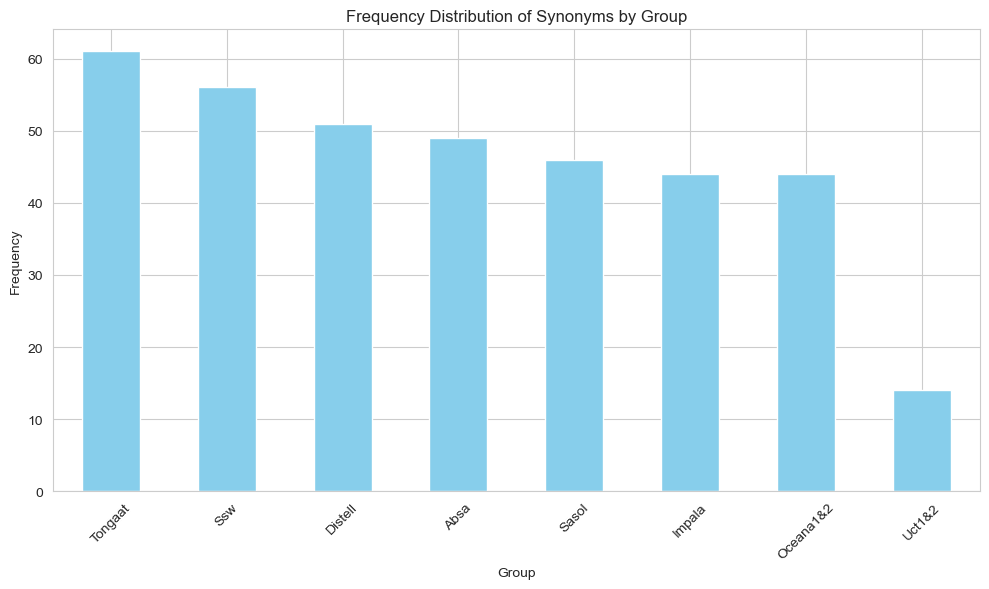

In [42]:
# Calculate the frequency of synonyms for each group
group_counts = AMKEY_Synonyms["Group"].value_counts()

# Plotting the frequency distribution
plt.figure(figsize=(10, 6))
group_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency Distribution of Synonyms by Group')
plt.xlabel('Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the frequency counts for each group
print("Frequency counts for each group:\n", group_counts)

# Show the plot
plt.show()

## Optimizing Query Processing for LLMs
I'm concentrating on fine-tuning the questions we pose to the Language Model for specific documents. The goal is to make our API requests more efficient by cutting down on unrelated answers and decreasing random outputs. Here's how we'll approach the queries: First, we'll pull out activity metrics that match up with client metrics for groups having similar terms. For groups like 'clicks' and 'picknpay,' we'll retrieve activity metrics that were recorded with values in 2021.

In [43]:
companies_metrics = {}

# Iterate over each row in the DataFrame
for index, row in train.dropna(subset=['2021_Value']).iterrows():
    # Split the ID value based on '_'
    parts = row['ID'].split('_')
    # Extract the name and number
    name = parts[2]
    number = parts[0]
    # Check if the name already exists in the dictionary
    if name in companies_metrics:
        # If it exists, append the number to the list
        companies_metrics[name].append(int(number))
    else:
        # If it doesn't exist, create a new entry with the number as a list
        companies_metrics[name] = [int(number)]

In [44]:
def relative_queries(df):
    Relative_queries=dict()
    # Relative_queries=
    for doc_ID in tqdm(all_documents_merged.keys()):
        if doc_ID not in ['Clicks','Picknpay']:
            Relative_queries[doc_ID]=df[df['Group']==doc_ID]["ActivityMetric"].to_list()
        else:
            Relative_queries[doc_ID]=list(AMKEY_qs[AMKEY_qs['AMKEY'].isin(companies_metrics[doc_ID])]['ActivityMetric'].values)
    return Relative_queries

In [45]:
Relative_queries=relative_queries(AMKEY_Synonyms)
Relative_queries.keys()

100%|██████████| 10/10 [00:00<00:00, 1092.35it/s]


dict_keys(['Clicks', 'Absa', 'Ssw', 'Sasol', 'Impala', 'Picknpay', 'Distell', 'Tongaat', 'Oceana1&2', 'Uct1&2'])

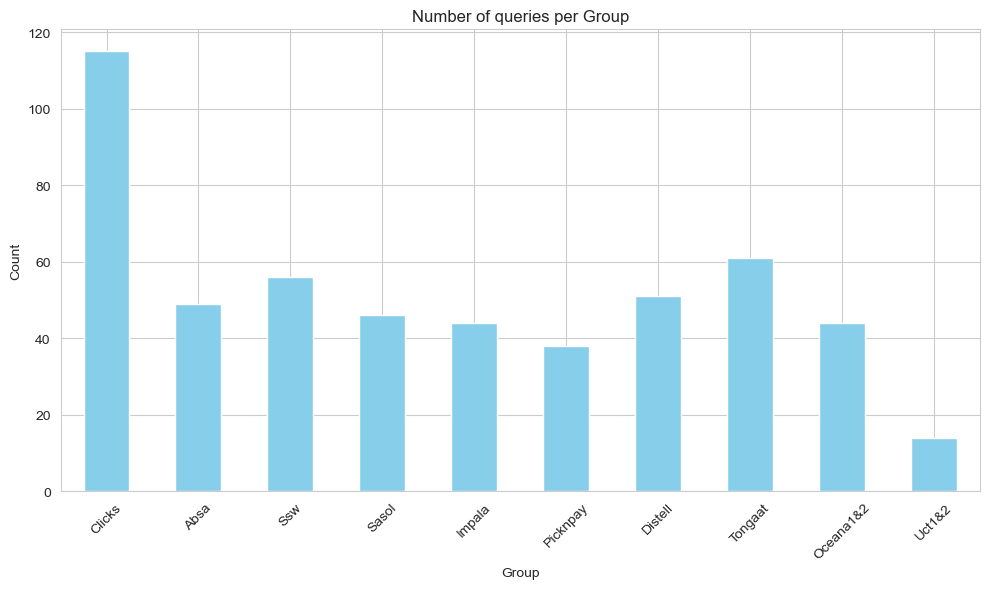

,Clicks,Absa,Ssw,Sasol,Impala,Picknpay,Distell,Tongaat,Oceana1&2,Uct1&2
0,115,49,56,46,44,38,51,61,44,14


In [46]:
group_counts = {doc_ID: len(Relative_queries[doc_ID]) for doc_ID in all_documents_merged.keys()}

# Convert dictionary to pandas Series
group_counts_series = pd.Series(group_counts)

# Plotting
plt.figure(figsize=(10, 6))
group_counts_series.plot(kind='bar', color='skyblue')
plt.title('Number of queries per Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
pd.DataFrame({doc_ID: len(Relative_queries[doc_ID]) for doc_ID in all_documents_merged.keys()},index=[0])

# Q&A LLM Interaction and Results

In [47]:
embeddings = select_embeddings_model(LLM_service="GIST")
llm=LLM_choice(name='opus')

In [48]:
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='avsolatorio/GIST-Embedding-v0', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [49]:
llm

ChatAnthropic(model='claude-3-opus-20240229', max_tokens=4096, temperature=0.1, anthropic_api_key=SecretStr('**********'), _client=<anthropic.Anthropic object at 0x000001C41209D710>, _async_client=<anthropic.AsyncAnthropic object at 0x000001C412087250>)

---

**Function: `LLMs_Result(Relative_queries, llm, embeddings, QA_CHAIN_PROMPT)`**  
*Purpose*: This function asks the LLM all relevant queries for each document in a cost-efficient manner, feeding it the 20 most relevant pages (a tunable parameter) for specific documents to generate accurate answers. It compiles and returns these answers for each document, implementing a pause between processing each one to not exceed the number of requests per minute.

---

In [50]:
def LLMs_Result(Relative_queries, llm, embeddings, QA_CHAIN_PROMPT):
    documents_answers = dict()
    for doc_ID in tqdm(all_documents_merged.keys()):
        docs = all_documents_merged[doc_ID]
        db = create_vectorstore(embeddings,docs)
        queries = Relative_queries[doc_ID]

        qa_chain = RetrievalQA.from_chain_type(
                llm,
                chain_type="stuff",
                retriever=db.as_retriever(search_type="similarity", search_kwargs={"k":20}),
                return_source_documents=True,
                chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
                )
        questions_  = "\n".join(["-" + s for s in queries])
        result = qa_chain({"query": questions_})
        print(result["result"])
        if doc_ID in documents_answers.keys():
            documents_answers[doc_ID] = documents_answers[doc_ID] + '\n' + result["result"]
        else:
            documents_answers[doc_ID] = result["result"]
    return documents_answers

start_time = time.perf_counter()
documents_answers = LLMs_Result(Relative_queries, llm, embeddings, QA_CHAIN_PROMPT)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

 10%|█         | 1/10 [02:30<22:35, 150.61s/it]

- Audit committee meeting attendance rate: [2022: N/A, 2021: N/A]
- BBBEE procurement spend from Exempt Micro Enterprises (EMEs), Qualifyimg Small Enterprises (QSEs) & Empowering Suppliers that are >51 black owned: [2022: N/A, 2021: N/A]
- B-BBEE Scorecard Level: [2022: 4, 2021: 4]
- Percentage of black board members: [2022: 60, 2021: 64]
- Board meeting attendance rate: [2022: N/A, 2021: N/A]
- Board members between 30 - 50: [2022: N/A, 2021: N/A]
- Board members over 50: [2022: N/A, 2021: N/A]
- Board members under 30: [2022: N/A, 2021: N/A]
- Cost of sales as per income statement: [2022: N/A, 2021: N/A]
- Depreciation as per income statement: [2022: N/A, 2021: N/A]
- Employee wages and benefits: [2022: N/A, 2021: N/A]
- Finance cost per income statement: [2022: N/A, 2021: N/A]
- GHG Scope 1 emissions: [2022: 4087, 2021: 2339]
- GHG Scope 2 emissions: [2022: 110099, 2021: 109023]
- GHG Scope 3 emissions: [2022: 34740, 2021: 34686]
- Greenhouse Gas (GHG) intensity rate: [2022: 16, 202

 20%|██        | 2/10 [03:34<13:18, 99.86s/it] 

- BBBEE procurement spend from Exempt Micro Enterprises (EMEs), Qualifyimg Small Enterprises (QSEs) & Empowering Suppliers that are >51 black owned: [2022: 11400000000, 2021: 12900000000]
- B-BBEE Scorecard Level: [2022: 1, 2021: 1]
- Board meeting attendance rate: [2022: 98, 2021: 98]
- Board members between 30 - 50: [2022: N/A, 2021: N/A]
- Board members over 50: [2022: 12, 2021: 12]
- Employee wages and benefits: [2022: 27873000000, 2021: 26133000000]
- Fatal injury frequency rate (FIFR): [2022: 0, 2021: 0]
- GHG Scope 1 emissions: [2022: 15885, 2021: 12276]
- GHG Scope 2 emissions: [2022: 138157, 2021: 158756]
- GHG Scope 3 emissions: [2022: 23447, 2021: 16205]
- Greenhouse Gas (GHG) intensity rate: [2022: 4.37, 2021: 5.02]
- Lost-time injury frequency rate (LTIFR): [2022: N/A, 2021: N/A]
- Natural gas consumed: [2022: 34423152, 2021: 35405866]
- Non-hazardous waste sent to legal landfill: [2022: 193, 2021: 250]
- Number of work-related fatalities: [2022: 0, 2021: 0]
- Number of fe

 30%|███       | 3/10 [05:00<10:54, 93.44s/it]

- Air emissions of the following pollutants: (3) SOx: [2022: 2577.5, 2021: 1747]
- Area of forestland managed by the entity: [2022: N/A, 2021: N/A]
- Area of forestland restored and or rehabilitated: [2022: 72, 2021: N/A]
- Board members between 30 - 50: [2022: N/A, 2021: N/A]
- Board members over 50: [2022: N/A, 2021: N/A]
- Employee wages and benefits: [2022: 26544000000, 2021: 26214000000]
- GHG Scope 3 emissions: [2022: 1137000, 2021: 1506000]
- Greenhouse Gas (GHG) intensity rate: [2022: 0.13, 2021: 0.16]
- Hazardous waste recycled: [2022: N/A, 2021: N/A]
- Hazardous waste to legal landfill: [2022: N/A, 2021: N/A]
- Lost-time injury frequency rate (LTIFR): [2022: 4.41, 2021: 6.02]
- Medically treated injury frequency rate (MTIFR): [2022: 0.66, 2021: 1.08]
- Non-hazardous waste sent to legal landfill: [2022: N/A, 2021: N/A]
- Number of environmental incidents with a negative impact: [2022: 2, 2021: 5]
- Number of work-related fatalities: [2022: 5, 2021: 21]
- Number of female board

 40%|████      | 4/10 [06:08<08:18, 83.16s/it]

- Air emissions of the following pollutants: (2) NOx (excluding N2O): [2022: 122040, 2021: 118700]
- Air emissions of the following pollutants: (3) SOx: [2022: 166880, 2021: 161870]
- Air emissions of the following pollutants: (4) particulate matter (PM10): [2022: 7630, 2021: 8220]
- Air emissions of the following pollutants: (5)  volatile organic compounds (VOCs): [2022: 13420, 2021: 26300]
- Area of forestland with protected conservation status: [2022: N/A, 2021: N/A]
- B-BBEE Scorecard Level: [2022: 3, 2021: 3]
- Employee wages and benefits: [2022: N/A, 2021: N/A]
- Fatal injury frequency rate (FIFR): [2022: 0.001, 2021: 0.007]
- GHG Scope 1 emissions: [2022: N/A, 2021: N/A]
- GHG Scope 2 emissions: [2022: N/A, 2021: N/A]
- Hazardous waste: [2022: 277000, 2021: 255000]
- Lost-time injury frequency rate (LTIFR): [2022: N/A, 2021: N/A]
- Natural gas consumed: [2022: N/A, 2021: N/A]
- Non-hazardous waste: [2022: 207000, 2021: 223000]
- Number of work-related fatalities: [2022: 2, 2021:

 50%|█████     | 5/10 [07:07<06:12, 74.49s/it]

- NOx (excluding N2O): [2022: 29513, 2021: 31571]
- SOx: [2022: 34847, 2021: 32602]
- Area of forestland restored and or rehabilitated: [2022: 46, 2021: 23]
- Fatal injury frequency rate (FIFR): [2022: 0.056, 2021: 0.176]
- GHG Scope 1 emissions: [2022: N/A, 2021: N/A]
- GHG Scope 2 emissions: [2022: N/A, 2021: N/A]
- Hazardous waste recycled: [2022: N/A, 2021: N/A]
- Lost-time injury frequency rate (LTIFR): [2022: 4.21, 2021: 4.92]
- Medically treated injury frequency rate (MTIFR): [2022: 5.56, 2021: 4.92]
- Number of black people/HDSA in executive management: [2022: N/A, 2021: N/A]
- Number of black people/HDSA in junior management: [2022: N/A, 2021: N/A]
- Number of black people/HDSA in middle management: [2022: N/A, 2021: N/A]
- Number of black people/HDSA in senior management: [2022: N/A, 2021: N/A]
- Number of black women in middle management: [2022: N/A, 2021: N/A]
- Number of black women in executive management: [2022: N/A, 2021: N/A]
- Number of black women in junior managemen

 60%|██████    | 6/10 [08:05<04:35, 68.90s/it]

Here is the requested data in the specified format:

- BBBEE procurement spend from Exempt Micro Enterprises (EMEs), Qualifyimg Small Enterprises (QSEs) & Empowering Suppliers that are >51 black owned: [2022: N/A, 2021: N/A]
- Board meeting attendance rate: [2022: 100%, 2021: 100%]  
- Fatal injury frequency rate (FIFR): [2022: 0.00, 2021: 0.00]
- GHG Scope 1 emissions: [2022: 183614, 2021: 123421]
- GHG Scope 2 emissions: [2022: 816944, 2021: 766174]
- GHG Scope 3 emissions: [2022: 475222, 2021: 482615]
- Lost-time injury frequency rate (LTIFR): [2022: 2.54, 2021: 2.3]
- Number of Medical Treatment Cases (MTCs, i.e. injuries on duty leading to medical treatment, but no lost days): [2022: 375, 2021: 102]
- Number of environmental incidents with a negative impact: [2022: 0, 2021: 0]
- Number of work-related fatalities: [2022: 0, 2021: 0]
- Number of female board members: [2022: 5, 2021: 5]
- Number of lost time injuries for employees: [2022: 1247, 2021: 1157]
- Number of occupational in

 70%|███████   | 7/10 [09:09<03:22, 67.34s/it]

- B-BBEE Scorecard Level: [2022: 3, 2021: 4]
- Board meeting attendance rate: [2022: 93.7, 2021: 95.8]
- Employee wages and benefits: [2022: 1822391105, 2021: N/A]
- GHG Scope 1 emissions: [2022: 76173, 2021: 69478]
- GHG Scope 2 emissions: [2022: 92647, 2021: 64893]
- GHG Scope 3 emissions: [2022: 320431, 2021: 296909]
- Hazardous waste: [2022: 77.82, 2021: N/A]
- Lost-time injury frequency rate (LTIFR): [2022: 0.69, 2021: 1.13]
- Non-hazardous waste sent to legal landfill: [2022: 113, 2021: N/A]
- Number of employees living with disabilities (PwD): [2022: 54, 2021: 60]
- Number of work-related fatalities: [2022: 0, 2021: 1]
- Number of female board members: [2022: 3, 2021: 3]
- Number of lost time injuries for employees: [2022: 31, 2021: 31]
- Number of occupational diseases: [2022: 22, 2021: 6]
- Number of occupational injuries: [2022: 343, 2021: 32]
- Percentage of black people/ HDSA in workforce: [2022: 75, 2021: 75]
- Percentage of employees covered by collective agreements: [202

 80%|████████  | 8/10 [10:13<02:12, 66.35s/it]

- All Inury Frequency Rate (Injuries/1m hrs worked): [2022: N/A, 2021: N/A]
- Area of forestland owned: [2022: N/A, 2021: N/A]
- B-BBEE Scorecard Level: [2022: N/A, 2021: N/A]
- Board meeting attendance rate: [2022: N/A, 2021: N/A]
- Energy Efficiency (Energy consumption per saleable output): [2022: N/A, 2021: 16.63]
- Fatal injury frequency rate (FIFR): [2022: N/A, 2021: N/A]
- GHG Scope 1 emissions: [2022: N/A, 2021: N/A]
- GHG Scope 2 emissions: [2022: N/A, 2021: N/A]
- Hazardous waste to legal landfill: [2022: N/A, 2021: N/A]
- Lost-time injury frequency rate (LTIFR): [2022: N/A, 2021: N/A]
- Natural gas consumed: [2022: N/A, 2021: N/A]
- Non-hazardous waste sent to legal landfill: [2022: N/A, 2021: N/A]
- Number of employees living with disabilities (PwD): [2022: N/A, 2021: N/A]
- Number of environmental incidents with a negative impact: [2022: N/A, 2021: 5]
- Number of work-related fatalities: [2022: N/A, 2021: 1]
- Number of female board members: [2022: N/A, 2021: N/A]
- Number 

 90%|█████████ | 9/10 [11:17<01:05, 65.53s/it]

- BBBEE procurement spend from Exempt Micro Enterprises (EMEs), Qualifyimg Small Enterprises (QSEs) & Empowering Suppliers that are >51 black owned: [2022: 1978855785, 2021: N/A]
- BBBEE procurement spend from Qualifyimg Small Enterprises (QSEs) as a % of total spend: [2022: 14.99, 2021: 12.86]
- B-BBEE Scorecard Level: [2022: 1, 2021: 1]
- Employee wages and benefits: [2022: 1200000000, 2021: 1000000000]
- Fatality rate: [2022: 1, 2021: N/A]
- GHG Scope 1 emissions: [2022: 154577, 2021: 132661]
- GHG Scope 2 emissions: [2022: 50526, 2021: 51007]
- GHG Scope 3 emissions: [2022: 72232, 2021: 63404]
- Infrastructure development in host communities: [2022: 9642.79, 2021: N/A]
- Lost-time injury frequency rate (LTIFR): [2022: 0.93, 2021: 1.15]
- Number of black people/HDSA  in junior management: [2022: N/A, 2021: N/A]
- Number of black people/HDSA  in middle management: [2022: N/A, 2021: N/A]
- Number of black people/HDSA  in senior management: [2022: N/A, 2021: N/A]
- Number of black wome

100%|██████████| 10/10 [11:43<00:00, 70.39s/it]

- Depreciation as per income statement: [2022: N/A, 2021: 486077000]
- Employee wages and benefits: [2022: N/A, 2021: 3689395000]
- Finance cost per income statement: [2022: N/A, 2021: 2544000]
- GHG Scope 1 emissions: [2022: N/A, 2021: N/A]
- GHG Scope 2 emissions: [2022: N/A, 2021: N/A]
- GHG Scope 3 emissions: [2022: N/A, 2021: N/A]
- Other Income as per income statement: [2022: N/A, 2021: 1238000]
- Revenue: [2022: N/A, 2021: 4572355000]
- Total assets as per balance sheet: [2022: N/A, 2021: N/A]
- Total number of employees: [2022: N/A, 2021: N/A]
- GHG Scope 1 emissions + GHG Scope 2 emissions: [2022: N/A, 2021: N/A]
- A description of the mechanisms and steps taken to ensure privacy and security of consumer data: [2022: N/A, 2021: N/A]
- GHG Intensity (GHG Scope 1 +Scope 2 per Revenue): [2022: N/A, 2021: N/A]
- Total Absolute GHG emissions (scope 1 - 3): [2022: N/A, 2021: N/A]
Elapsed time: 703.91 seconds


# 7. Post-Processing and Evaluation

## Data Extraction and Formatting

---

**Function: `extract_data_refined(input_string)`**  
*Purpose*: This function cleans an input string, extracts variable names and corresponding year-value pairs, and returns them in a structured format. It handles various string formats and constructs a dictionary to map years to their respective values.

---

**Function: `create_data_frame(extracted_data_refined)`**  
*Purpose*: This function creates a DataFrame from refined extracted data, organizing it by variable names and corresponding years. It ensures unique years are sorted as columns and replaces missing data with a placeholder text, offering a structured view of the data for analysis.

---

**Function: `convert_to_number(s)`**  
*Purpose*: This utility function converts a string to a floating-point number, handling cases where the string contains a percentage symbol. It returns a float value or zero in cases where conversion is not feasible.

---

In [51]:
def extract_data_refined(input_string):
    # Remove initial hyphen and space if present
    cleaned_string = re.sub(r'^-\s*', '', input_string)

    # Split the string into variable name and data pairs using the last colon before the data pairs
    split_position = cleaned_string.rfind(': [')
    if split_position == -1:
        return "Variable name not found."

    variable_name = cleaned_string[:split_position].strip()

    # Extract the number-string pairs
    data_pairs_string = cleaned_string[split_position + 2:]
    data_pairs_match = re.findall(r"(\d+):\s*([^,\]]+)", data_pairs_string)

    # Construct the dictionary from the pairs
    data_dict = {int(number): value.strip() for number, value in data_pairs_match}

    # Create the final list containing the variable name and the dictionary
    result = [variable_name, data_dict]

    return result

def create_data_frame(extracted_data_refined):
    # Extract unique years and sort them
    unique_years = sorted({year for _, data in extracted_data_refined for year in data})

    # Initialize a DataFrame with unique years as columns
    df = pd.DataFrame(columns=["Variable Name"] + unique_years)

    # Populate the DataFrame with data
    for variable_name, data in extracted_data_refined:
        row = [variable_name] + [data.get(year, '') for year in unique_years]
        df.loc[len(df)] = row

    # Replace empty strings with NaN and filter for specific years
    df = df.replace('', 'data not provided') #[['Variable Name', 2019, 2020, 2021, 2022]]

    return df

# Function to convert string to number
def convert_to_number(s):
    try:
        # Remove '%' if it's the last character
        if s.endswith('%'):
            s = s[:-1]

        return float(s)
    except ValueError:
        # Handle the case where the string cannot be converted to a float
        return 0.0

In [52]:
answers = dict()
for keys, values in documents_answers.items():
    answers[keys] = values.split('\n')

---

**Function: `process_documents(answers, YEAR)`**  
*Purpose*: This function processes document answers by refining and organizing data into structured DataFrame formats for specific variables and years. It appends document-specific details like page number and confidence score based on similarity searches, and finally, formats and returns a comprehensive DataFrame with relevant metrics, including a calculated year-specific value.

---

In [53]:
def process_documents(answers, YEAR):
    QR = AMKEY_qs.ActivityMetric.values
    dfs = pd.DataFrame()

    for doc in tqdm(answers.keys()):
        extracted_list = []
        docs = all_documents_merged[doc]
        db = create_vectorstore(embeddings, docs)

        for string in answers[doc]:
            try:
                extracted_data_refined = extract_data_refined(string)
                create_data_frame([extracted_data_refined])
                extracted_list.append(extracted_data_refined)
            except:
                continue

        df = create_data_frame(extracted_list)
        df["document_name"] = doc
        df = df[df["Variable Name"].isin(QR)] # correct variable names

        # Initialize new columns
        df['page_number'] = None
        df['confidence_score'] = None

        for index, row in df.iterrows():
            query = row["Variable Name"]
            document_source = db.similarity_search_with_relevance_scores(query, k=1)[0]
            page = document_source[0].metadata['page']
            score = document_source[1]

            df.at[index, 'page_number'] = page
            df.at[index, 'confidence_score'] = score

        try:
            df = df[['Variable Name', "document_name", YEAR, 'page_number', 'confidence_score']]
        except:
            print(f'\nNo values were extracted for the year {YEAR} for the document {doc}')
            continue

        dfs = pd.concat([dfs, df])

    dfs["AMKEY"] = dfs["Variable Name"].apply(lambda x: AMKEY_qs[AMKEY_qs['ActivityMetric'] == x]["AMKEY"].iloc[0])
    dfs['ID'] = dfs.apply(lambda row: str(row['AMKEY']) + '_X_' + row['document_name'], axis=1)
    dfs[f'{YEAR}_value'] = dfs[YEAR].apply(convert_to_number)

    return dfs[['ID','Variable Name', YEAR,'page_number', 'confidence_score', f'{YEAR}_value' ]]


In [54]:
process_documents(answers, YEAR)

100%|██████████| 10/10 [00:39<00:00,  4.00s/it]


,ID,Variable Name,2022,page_number,confidence_score,2022_value
0,35_X_Clicks,Audit committee meeting attendance rate,N/A,16,0.479788,0.0
1,46_X_Clicks,BBBEE procurement spend from Exempt Micro Ente...,N/A,18,0.631564,0.0
2,49_X_Clicks,B-BBEE Scorecard Level,4,16,0.518139,4.0
3,50_X_Clicks,Percentage of black board members,60,4,0.541434,60.0
4,52_X_Clicks,Board meeting attendance rate,N/A,16,0.468244,0.0
...,...,...,...,...,...,...
9,523_X_Uct1&2,Total number of employees,N/A,58,0.537109,0.0
10,749_X_Uct1&2,GHG Scope 1 emissions + GHG Scope 2 emissions,N/A,8,0.664373,0.0
11,759_X_Uct1&2,A description of the mechanisms and steps take...,N/A,20,0.488544,0.0
12,882_X_Uct1&2,GHG Intensity (GHG Scope 1 +Scope 2 per Revenue),N/A,8,0.606846,0.0


In [55]:
answers_processed = process_documents(answers, YEAR)
sample_sub = pd.read_csv('SampleSubmission.csv')
unique_id = answers_processed['ID'].unique()
sample_sub[f'{YEAR}_Value']  = sample_sub.apply(lambda row: answers_processed[answers_processed['ID']==row['ID']]['2022_value'].iloc[0] if row['ID'] in unique_id else 0.0, axis=1).astype(float)

100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


In [70]:
sample_sub.to_csv('Winning.csv', index=False)

## Analysis of Findings

Evaluating Predictive Analytics for **2021**: **Accuracy**, **Precision**, **Recall**, and **F1 Score**

In [57]:
answers_processed = process_documents(answers, 2021)
predictions_2021 = pd.read_csv('SampleSubmission.csv')
unique_id = answers_processed['ID'].unique()
predictions_2021['2021_Value']  = predictions_2021.apply(lambda row: answers_processed[answers_processed['ID']==row['ID']]['2021_value'].iloc[0] if row['ID'] in unique_id else 0.0, axis=1).astype(float)
predictions_2021 = predictions_2021[['ID', '2021_Value']]

100%|██████████| 10/10 [00:41<00:00,  4.15s/it]


In [58]:
predictions_2021

,ID,2021_Value
0,100_X_Absa,0.0
1,100_X_Clicks,0.0
2,100_X_Distell,0.0
3,100_X_Impala,0.0
4,100_X_Oceana1&2,0.0
...,...,...
5105,9_X_Picknpay,0.0
5106,9_X_Sasol,8220.0
5107,9_X_Ssw,0.0
5108,9_X_Tongaat,0.0


In [59]:
def convert_to_float(value):
    try:
        return float(value)
    except:
        return 0.0

predictions_2021.columns = ['ID', '2021_Value_predicted']
true_2021 = train[["ID", "2021_Value"]]
true_2021['2021_Value'] = true_2021['2021_Value'].apply(convert_to_float).fillna(0.0)

In [60]:
merged_df = pd.merge(true_2021, predictions_2021, on='ID', how='left')

In [61]:
y_true, y_pred = merged_df['2021_Value'].values, merged_df['2021_Value_predicted'].values

In [62]:
def calculate_metrics(y_true, y_pred):
    # Ensure that y_true and y_pred are of the same length
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must be of the same length.")

    true_positives = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    false_positives = sum(1 for true, pred in zip(y_true, y_pred) if true != pred and pred in y_true)
    false_negatives = sum(1 for true, pred in zip(y_true, y_pred) if true != pred and pred not in y_true)

    accuracy = true_positives / len(y_true)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score


def plot_metrics(metrics):
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = color_palette
    bar_width = 0.4

    # Creating a more visually appealing plot
    plt.figure(figsize=(12, 7))
    bars = plt.bar(metric_names, metrics, color=colors, width=bar_width, edgecolor='black')

    # Adding data labels on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Adding some extra visual elements
    plt.xlabel('Metrics', fontsize=12, fontweight='bold')
    plt.ylabel('Values', fontsize=12, fontweight='bold')
    plt.title('Performance Metrics', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=10, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1)

    # Show the plot
    plt.show()

In [63]:
# Calculate metrics
metrics = calculate_metrics(y_true, y_pred)
print(f'Accuracy: {metrics[0]}\nPrecision: {metrics[1]}\nRecall: {metrics[2]}\nF1 Score: {metrics[3]}')

Accuracy: 0.9438356164383561
Precision: 0.9588469184890656
Recall: 0.9836834591066694
F1 Score: 0.971106412966878


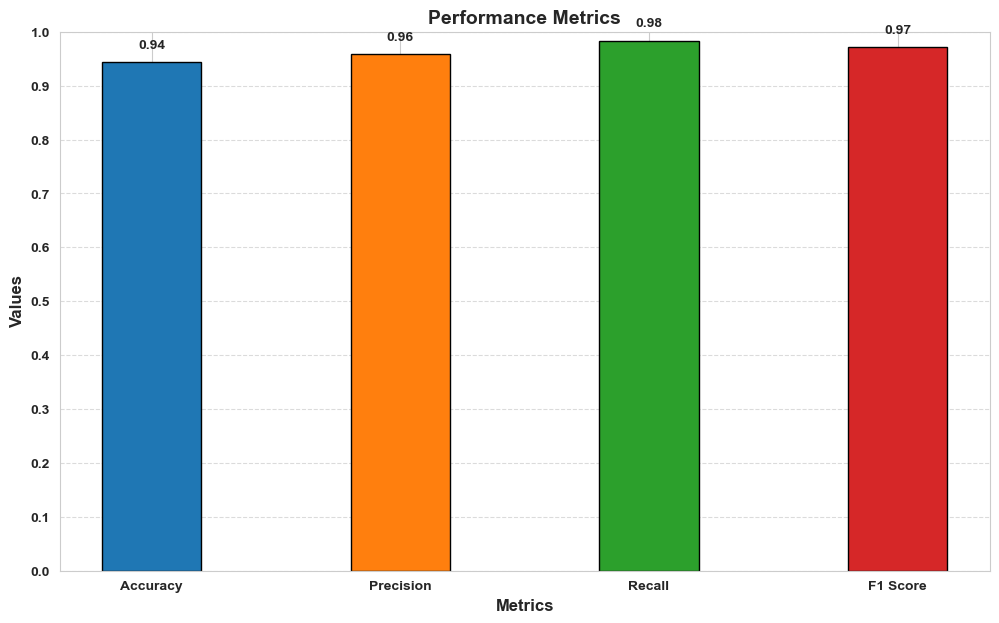

In [64]:
# Plot metrics
plot_metrics(metrics)

In [65]:
sample_sub['2022_Value'].value_counts()

2022_Value
0.00       4843
1.00          5
2.00          4
4.00          4
3.00          3
           ... 
77.90         1
29.30         1
81.44         1
78.00         1
7630.00       1
Name: count, Length: 242, dtype: int64

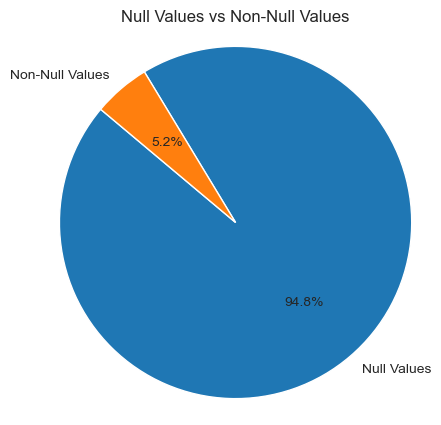

In [66]:
df=sample_sub.copy()
# Count null and non-null values
null_count = df[df['2022_Value']==0].count()[0]
non_null_count = df.shape[0]-null_count

# Create labels and values for the pie plot
labels = ['Null Values', 'Non-Null Values']
sizes = [null_count, non_null_count]

# Create a pie plot
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Null Values vs Non-Null Values')
plt.show()

### For each document

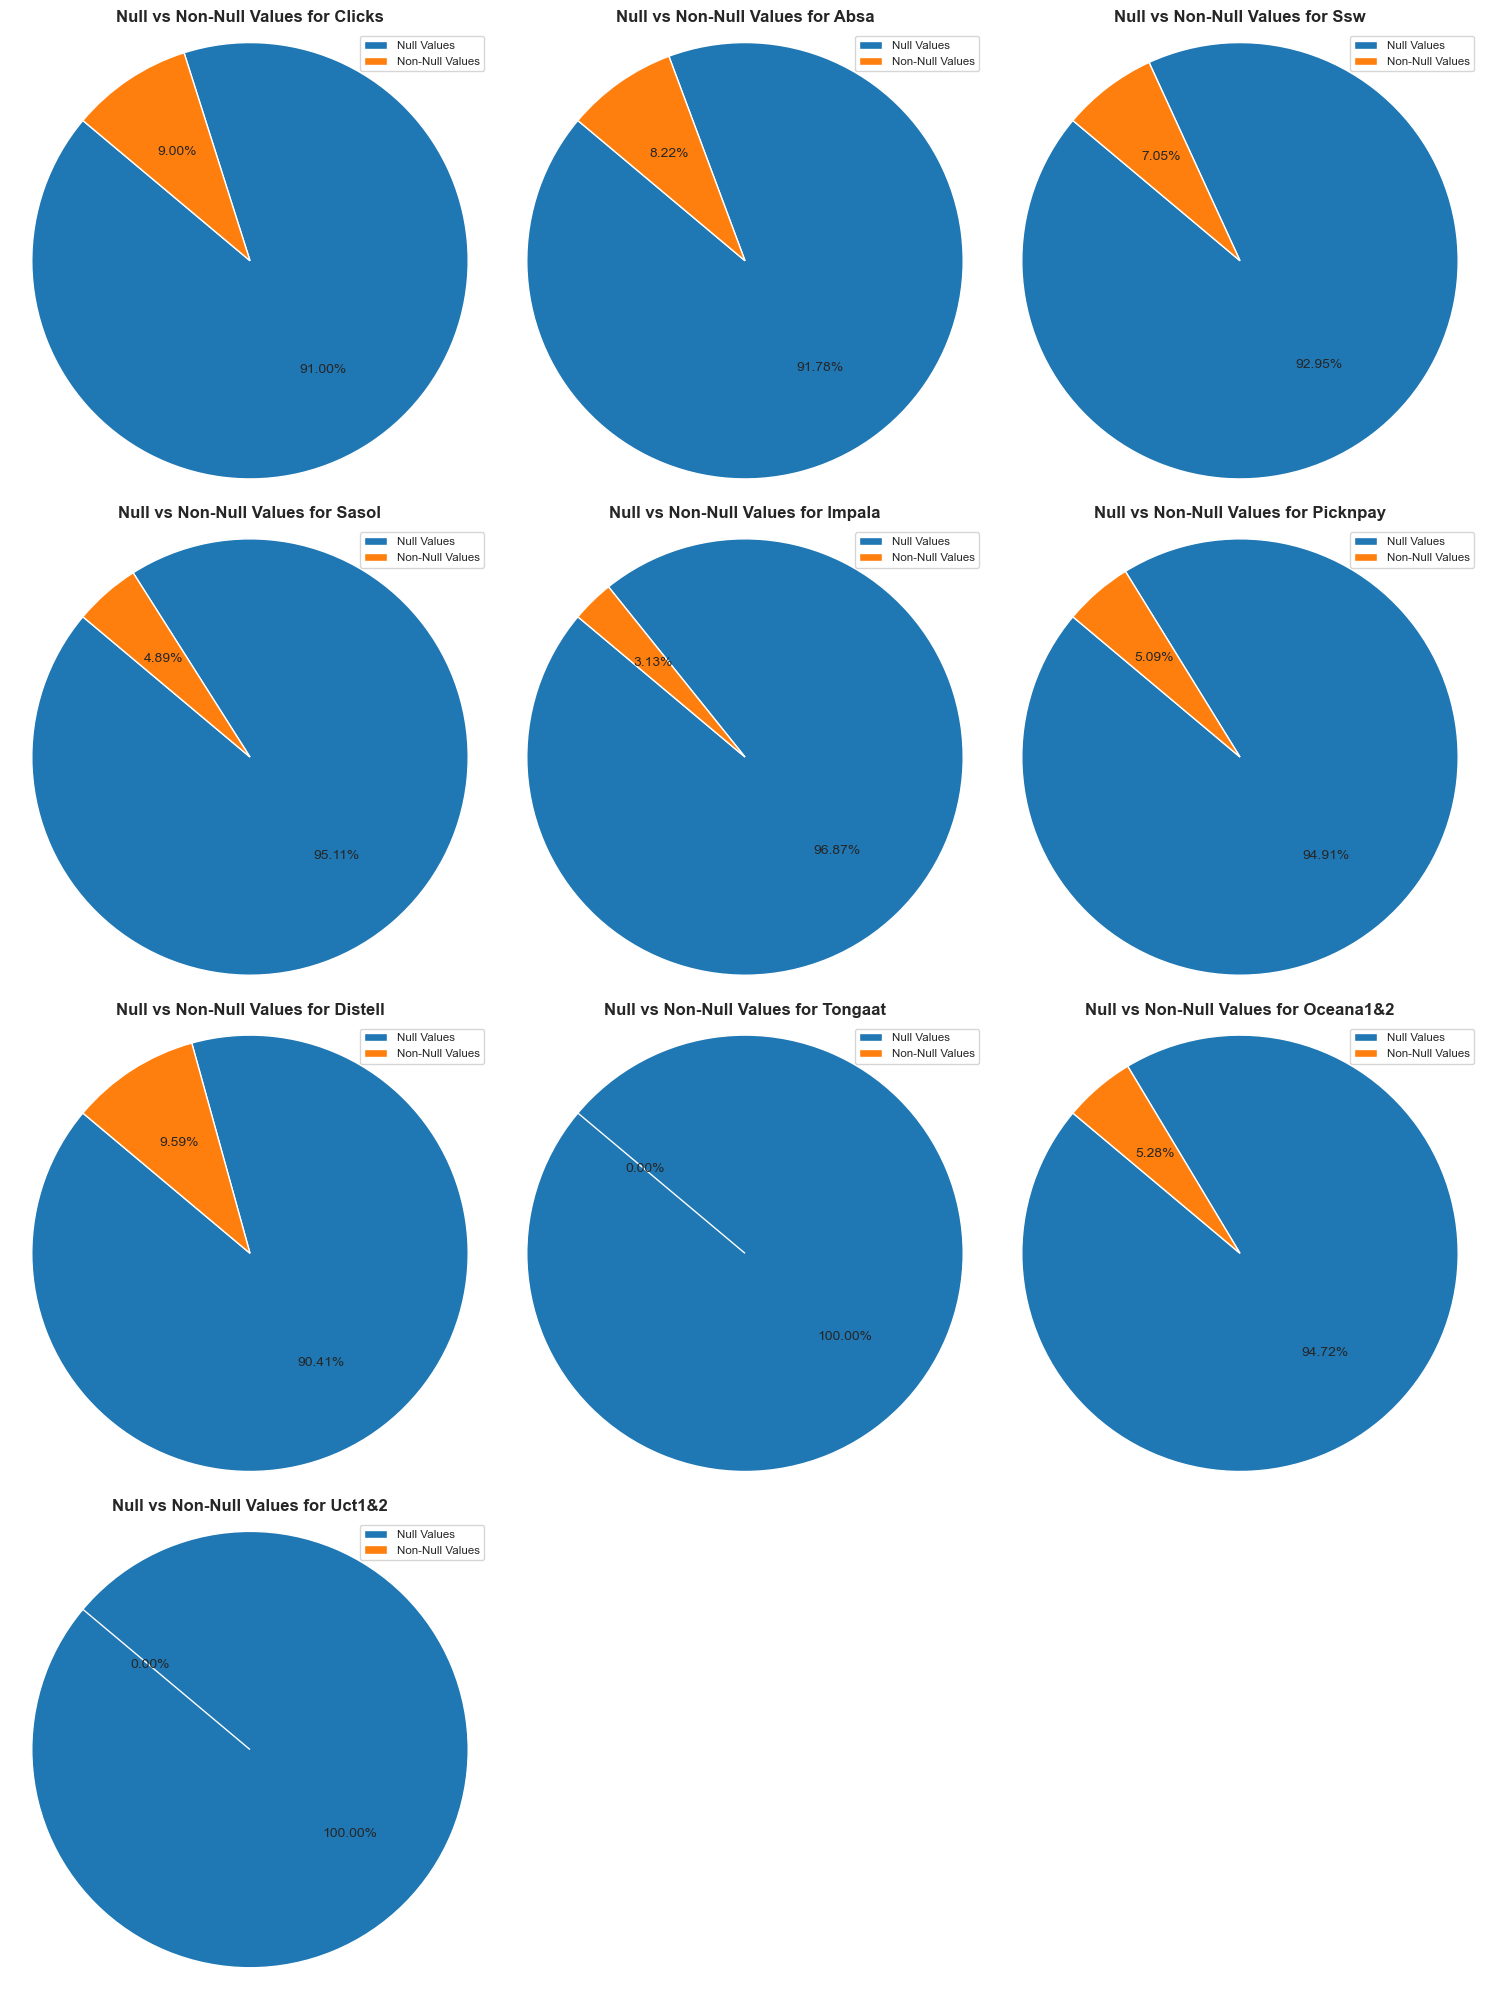

In [67]:
# Calculate number of rows needed
num_documents = len(all_documents_merged.keys())
num_rows = (num_documents + 2) // 3  # Ensure rounding up to the nearest integer

# Set up subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each document
for i, doc_ID in enumerate(all_documents_merged.keys()):
    df = sample_sub.copy()
    df = df[df['ID'].str.contains(doc_ID)]
    null_count = df[df['2022_Value'] == 0].count()[0]
    non_null_count = df.shape[0] - null_count

    # Create labels and values for the pie plot
    labels = ['Null Values', 'Non-Null Values']
    sizes = [null_count, non_null_count]

    # Plot pie chart in the respective subplot
    axes[i].pie(sizes, autopct='%1.2f%%', startangle=140)
    axes[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axes[i].set_title(f'Null vs Non-Null Values for {doc_ID}', fontweight='bold')
    axes[i].legend(labels, loc='upper right', fontsize='small')

# Hide empty subplots if needed
if num_documents % 3 != 0:
    for i in range(num_documents % 3, 3):
        axes[-i].axis('off')

# Add spacing between subplots
plt.tight_layout()

# Show plot
plt.show()

# 8. Export To HTML

Convert the notebook to HTML and potentially PDF for sharing and presentation

In [68]:
%%capture
!pip install nbconvert --quiet
!pip install pandoc
!pip install texlive-xetex texlive-fonts-recommended texlive-plain-generic

***This will export the notebook to HTML then we could Print it as PDF without worrying about LaTeX errors***

In [69]:
%%capture
!jupyter nbconvert --to html "./Top2-solution.ipynb" --output-dir='./'